In [1]:
import pandas as pd

In [2]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('/kaggle/input/tokenizer')

In [3]:
import torch
model = torch.load('/kaggle/input/model-7/model_distilbert.pt')

In [4]:
data = pd.read_csv('/kaggle/input/llm-dataset/filtered_data_clean.csv')

In [5]:
data.head()

,text,label,clean_text
0,We should keep the Electoral College for a num...,0,keep electoral college number reasons usually ...
1,Limiting car usage can actually be effective b...,0,limiting car usage actually effective belief l...
2,"Dear Principal,\n\nAfter school or during scho...",0,dear principal school school activities like b...
3,"Many people think that aliens are real, but th...",0,many people think aliens real theyre many peop...
4,I think if a student has a C average he or she...,0,think student c average may able participate s...


In [7]:
texts = data['clean_text'].tolist()
labels = data['label'].tolist()

In [24]:
val_texts = texts[50000:50000+2500] + texts[120001+50000:120001+50000+2500]
val_labels = labels[50000:50000+2500] + labels[120001+50000:120001+50000+2500]

(array([2500.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2500.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

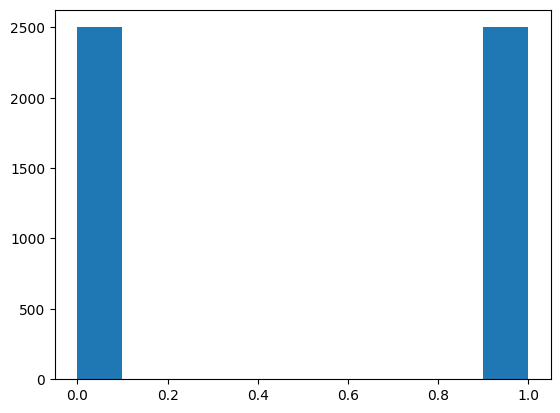

In [25]:
import matplotlib.pyplot as plt
plt.hist(val_labels)

In [43]:
val_texts = [str(text) for text in val_texts]

In [44]:
import torch.nn.functional as F

In [80]:
predictions = []

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [82]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [83]:
from tqdm.notebook import tqdm

In [84]:
model.eval()
with torch.no_grad():
    for text in tqdm(val_texts):
        enc = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
        input_ids = enc['input_ids'].to(device)
        attention_mask = enc['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits
        logits = F.softmax(logits)
        _,pred = torch.max(logits, dim=1)
        predictions.append(pred.item())

  0%|          | 0/5000 [00:00<?, ?it/s]

/tmp/ipykernel_42/1038105905.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)


In [86]:
len(predictions)

5000

In [89]:
from sklearn.metrics import accuracy_score

In [90]:
accuracy = accuracy_score(val_labels, predictions)
accuracy

0.9988

In [114]:
4994/5000

0.9988

In [94]:
def cal_TP_FP_TN_FN(labels, predictions):
    TP, FP, TN, FN = 0, 0, 0, 0
    for label, pred in zip(labels, predictions):
        if label==1 and pred==1:
            TP += 1
        elif label==1 and pred==0:
            FN += 1
        elif label==0 and pred==0:
            TN += 1
        else :
            FP += 1
    return TP, FP, TN, FN

In [97]:
TP, FP, TN, FN = cal_TP_FP_TN_FN(val_labels, predictions)

In [98]:
TP, FP, TN, FN 

(2496, 2, 2498, 4)

In [101]:
def cal_precision_recall(TP, FP, TN, FN):
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    return precision, recall

In [102]:
precision, recall = cal_precision_recall(TP, FP, TN, FN)
precision, recall

(0.9991993594875901, 0.9984)

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [111]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [112]:
class_names = ['Human_text', 'AI_text']

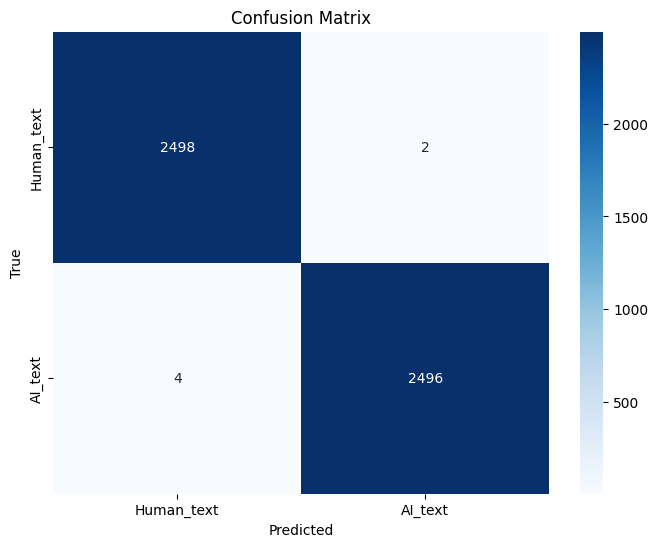

In [113]:
plot_confusion_matrix(val_labels, predictions, class_names)